In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score as F1

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

from collections import defaultdict
from tqdm import tqdm

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/CSC/fall2021/recsys/hw1/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CSC/fall2021/recsys/hw1


In [40]:
# читаем из файла фичи
raw_data = pd.read_csv('data/data.csv', usecols=['date_time', 'zone_id',
                                             'banner_id', 'oaid_hash',
                                             'campaign_clicks', 'os_id',
                                             'country_id', 'impressions',
                                             'clicks'])
raw_data.head(3)

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,1,1


In [41]:
# смотрим разброс по дням
sorted(set(raw_data['date_time'].map(lambda s: s[:10])))

['2021-09-01',
 '2021-09-26',
 '2021-09-27',
 '2021-09-28',
 '2021-09-29',
 '2021-09-30',
 '2021-10-01',
 '2021-10-02']

In [35]:
# удаляем 1 сентября, так как оно далеко от общей массы данных (по времени)
raw_data.drop(raw_data[raw_data['date_time'].map(lambda s: s[:10]) == '2021-09-01'].index, inplace=True, axis=0)

# Линейная модель

In [8]:
def feature_engineering(data, cols_to_drop):
  return data.drop(cols_to_drop, axis=1)

In [9]:
def train_val_test_split(data, last_train_day='2021-09-30', last_val_day='2021-10-02'):
  # обучаем one-hot encoder
  enc = OneHotEncoder(handle_unknown='ignore')
  enc.fit(data.drop(['clicks', 'date_time'], axis=1))

  # выделяем в train данные до last_train_day
  train_condition = data['date_time'].apply(lambda s: s.split()[0]) < last_train_day
  train_data = data[train_condition]

  X_train = train_data.drop(['clicks', 'date_time'], axis=1)
  X_train = enc.transform(X_train)
  y_train = train_data['clicks']

  # выделяем в val данные от last_train_day до last_val_day
  validate_condition = (data['date_time'].apply(lambda s: s.split()[0]) >= last_train_day) & (data['date_time'].apply(lambda s: s.split()[0]) < last_val_day)
  validate_data = data[validate_condition]

  X_val = validate_data.drop(['clicks', 'date_time'], axis=1)
  X_val = enc.transform(X_val)
  y_val = validate_data['clicks']

  # выделяем в test данные последнего дня
  test_condition = data['date_time'].apply(lambda s: s.split()[0]) >= last_val_day
  test_data = data[test_condition]

  X_test = test_data.drop(['clicks', 'date_time'], axis=1)
  X_test = enc.transform(X_test)
  y_test = test_data['clicks']

  return X_train, y_train, X_val, y_val, X_test, y_test



In [10]:
def create_model(X_train, y_train, fit_intercept=False, C=1):
  model = LogisticRegression(fit_intercept=fit_intercept, C=C, solver='liblinear').fit(X_train, y_train)

  return model

In [11]:
# подготавливаем данные
data = feature_engineering(raw_data, cols_to_drop=['oaid_hash', 'impressions'])

In [12]:
# разбиваем данные на train, val, test
%%time
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(data)

CPU times: user 40.6 s, sys: 5.18 s, total: 45.7 s
Wall time: 45.7 s


In [47]:
log_losses = []
C_arr = [100, 10, 1]

In [48]:
# перебираем параметры и сравниваем качество моделей
# fit_intercept=True
%%time
for C in tqdm(C_arr):
  model = create_model(X_train, y_train, fit_intercept=True, C=C)
  y_pred = model.predict_proba(X_val)

  loss = log_loss(y_val, y_pred)
  log_losses.append(loss)

100%|██████████| 3/3 [22:26<00:00, 448.71s/it]

CPU times: user 22min 23s, sys: 3.56 s, total: 22min 27s
Wall time: 22min 26s


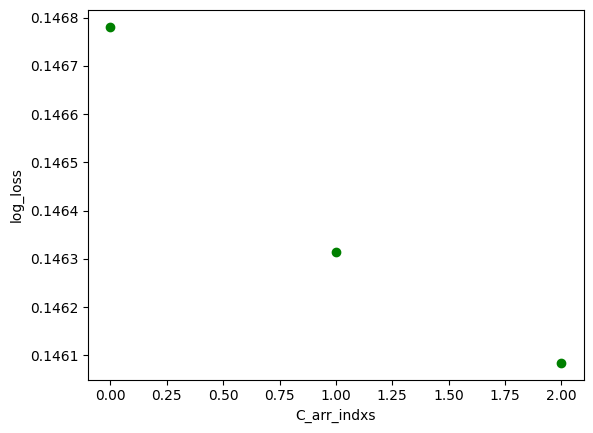

In [49]:
fig = plt.figure()
ax = plt.axes()

x = np.arange(len(C_arr))

plt.scatter(x, np.array(log_losses), c="g")
plt.xlabel("C_arr_indxs")
plt.ylabel("log_loss")
plt.show()

In [50]:
log_losses = []
C_arr = [100, 10, 1]

In [51]:
# перебираем параметры и сравниваем качество моделей
# fit_intercept=False
for C in tqdm(C_arr):
  model = create_model(X_train, y_train, fit_intercept=False, C=C)
  y_pred = model.predict_proba(X_val)

  loss = log_loss(y_val, y_pred)
  log_losses.append(loss)

100%|██████████| 3/3 [18:23<00:00, 367.67s/it]


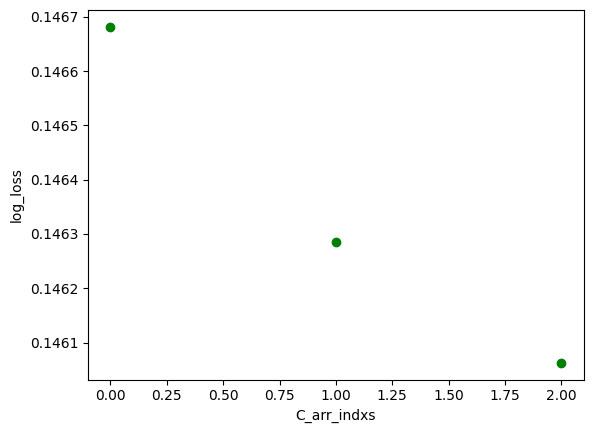

In [52]:
fig = plt.figure()
ax = plt.axes()

x = np.arange(len(C_arr))

plt.scatter(x, np.array(log_losses), c="g")
plt.xlabel("C_arr_indxs")
plt.ylabel("log_loss")
plt.show()

In [44]:
# обучаем модель, показавшую на val лучшее качество
%%time
model = create_model(X_train, y_train, fit_intercept=True, C=1)

CPU times: user 3min 7s, sys: 1.65 s, total: 3min 9s
Wall time: 3min 9s


In [45]:
y_pred = model.predict_proba(X_test)

In [46]:
print("Log-loss: {:.4f}".format(log_loss(y_test, y_pred)))

Log-loss: 0.1370
